In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,  classification_report, ConfusionMatrixDisplay
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Importing data

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False) # loading 70000 28x28 images (784 features each)

X, y = mnist.data, mnist.target

print(X)
print(X.shape)

print(y)
print(y.shape)

c:\Users\valvs\anaconda3\envs\python310\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(70000, 784)
['5' '0' '4' ... '4' '5' '6']
(70000,)


## PSNR Generation


$PSNR = 10 \cdot \log_{10}(\frac{MAX^2}{MSE})$

$\frac{PSNR}{10} = \log_{10}(\frac{MAX^2}{MSE})$

$10^\frac{PSNR}{10} = \frac{MAX^2}{MSE}$

$MSE = \frac{MAX^2}{10^\frac{PSNR}{10}}$

The value of MAX is 255 and we want a PSNR of 10dB, so the equation is:

$MSE = \frac{255^2}{10^{\frac{10}{10}}} = 6502.5$

In [3]:
def gen_10db_psnr():
    gaussian_noise = np.random.normal(0, np.sqrt(6502.5), X.shape[1])

    # mse = np.sum(gaussian_noise**2) / X.shape[1]
    # psnr = 10 * np.log10(255**2 / mse)
    # print(f'PSNR = {psnr} dB')

    return gaussian_noise

In [4]:
X_noisy = X.copy()

# Add 10dB PSNR to each image
for i in range(X.shape[0]):
    X_noisy[i] = X_noisy[i] + gen_10db_psnr()

## Plotting example images

Digit = 8


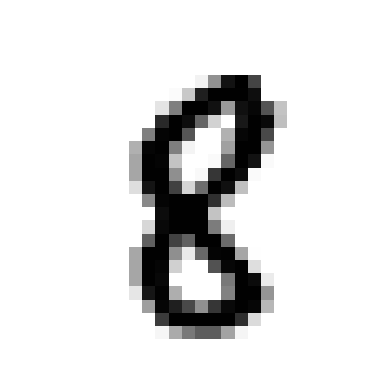

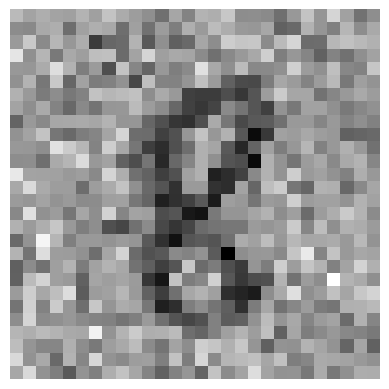

In [5]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

digit_index = np.random.randint(len(X))
# digit_index = 7545

print(f'Digit = {y[digit_index]}')

plot_digit(X[digit_index])
plt.show()

plot_digit(X_noisy[digit_index])
plt.show()


## Separating Data

- Train: 70%
- Validation: 10%
- Test: 20%

In [5]:
# MNIST is already split and into train and test, and is already shuffled!
X_train, X_val, X_test, y_train, y_val, y_test = X[:49000], X[49000:56000], X[56000:], y[:49000], y[49000:56000], y[56000:]

Xn_train, Xn_val, Xn_test = X_noisy[:49000], X_noisy[49000:56000], X_noisy[56000:]

(array([654., 705., 675., 738., 668., 693., 742., 682., 734., 709.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

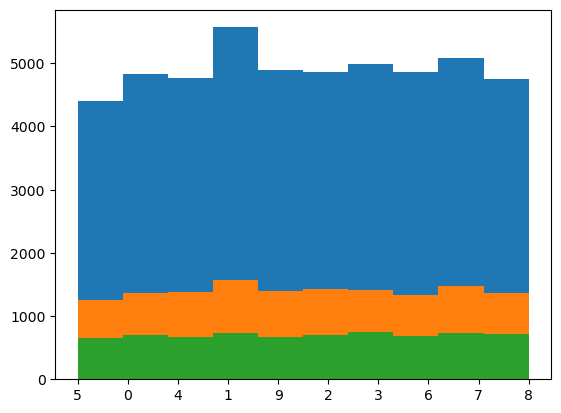

In [6]:
plt.hist(y_train)
plt.hist(y_test)
plt.hist(y_val)

## Naive Bayes

### Training original Dataset

In [8]:
naive_gaussian = GaussianNB() 

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=200)
}

grid_search = GridSearchCV(estimator=naive_gaussian, param_grid=param_grid, cv=5)

grid_search.fit(X_val, y_val)

best_params = grid_search.best_params_

print("Best params: ")
print(best_params)

Best params: 
{'var_smoothing': 0.08214343584919426}


In [6]:
naive_gaussian = GaussianNB(var_smoothing=0.08214343584919426)

naive_gaussian.fit(X_train, y_train)

GaussianNB(var_smoothing=0.08214343584919426)

Predict without noise

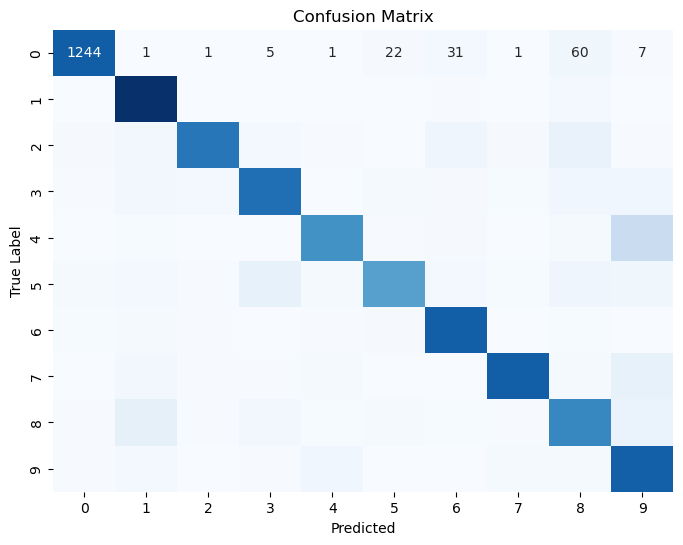

In [8]:
nb_predict = naive_gaussian.predict(X_test)
cm = confusion_matrix(y_test, nb_predict)

# Plota a matriz de confusão como um mapa de calor (heatmap)
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, nb_predict))
print(accuracy_score(y_test, nb_predict))

Predict with noise

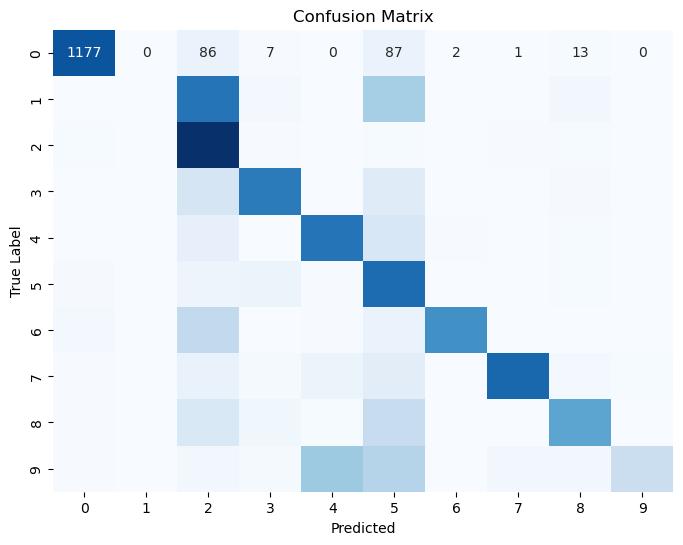

c:\Users\valvs\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\valvs\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\valvs\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1373
           1       0.00      0.00      0.00      1569
           2       0.38      0.96      0.55      1430
           3       0.81      0.69      0.75      1413
           4       0.62      0.73      0.67      1376
           5       0.35      0.84      0.50      1253
           6       0.98      0.64      0.78      1339
           7       0.95      0.73      0.82      1483
           8       0.78      0.54      0.64      1365
           9       0.93      0.23      0.36      1399

    accuracy                           0.61     14000
   macro avg       0.67      0.62      0.60     14000
weighted avg       0.67      0.61      0.59     14000

0.6130714285714286


In [9]:
nb_predict = naive_gaussian.predict(Xn_test)
cm = confusion_matrix(y_test, nb_predict)

# Plota a matriz de confusão como um mapa de calor (heatmap)
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, nb_predict))
print(accuracy_score(y_test, nb_predict))

### Training with noise

In [17]:
naive_gaussian = GaussianNB() 

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=200)
}

grid_search = GridSearchCV(estimator=naive_gaussian, param_grid=param_grid, cv=5)

grid_search.fit(Xn_val, y_val)

best_params = grid_search.best_params_

print("Best params: ")
print(best_params)

Best params: 
{'var_smoothing': 2.7049597304631315e-05}


In [10]:
naive_gaussian = GaussianNB(var_smoothing=2.7049597304631315e-05)

naive_gaussian.fit(Xn_train, y_train)

GaussianNB(var_smoothing=2.7049597304631315e-05)

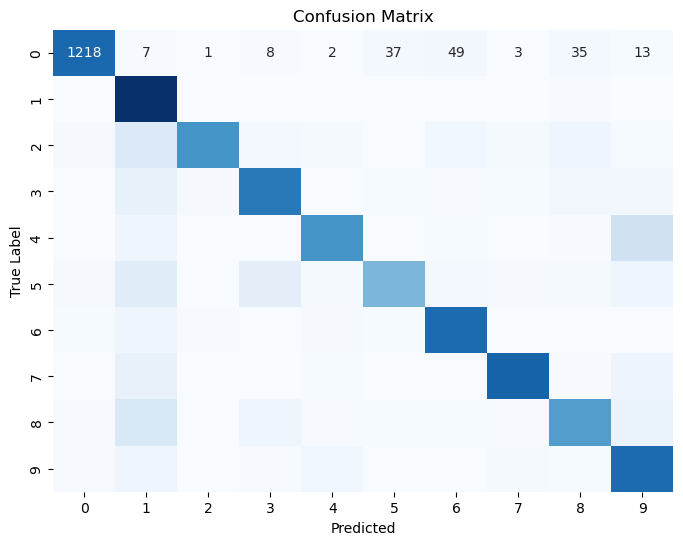

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1373
           1       0.59      0.99      0.74      1569
           2       0.95      0.67      0.79      1430
           3       0.80      0.79      0.80      1413
           4       0.85      0.69      0.77      1376
           5       0.89      0.57      0.69      1253
           6       0.86      0.90      0.88      1339
           7       0.92      0.84      0.88      1483
           8       0.79      0.65      0.72      1365
           9       0.65      0.86      0.74      1399

    accuracy                           0.79     14000
   macro avg       0.82      0.78      0.79     14000
weighted avg       0.82      0.79      0.79     14000

0.7893571428571429


In [11]:
nb_predict = naive_gaussian.predict(X_test)

cm = confusion_matrix(y_test, nb_predict)

# Plota a matriz de confusão como um mapa de calor (heatmap)
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, nb_predict))
print(accuracy_score(y_test, nb_predict))

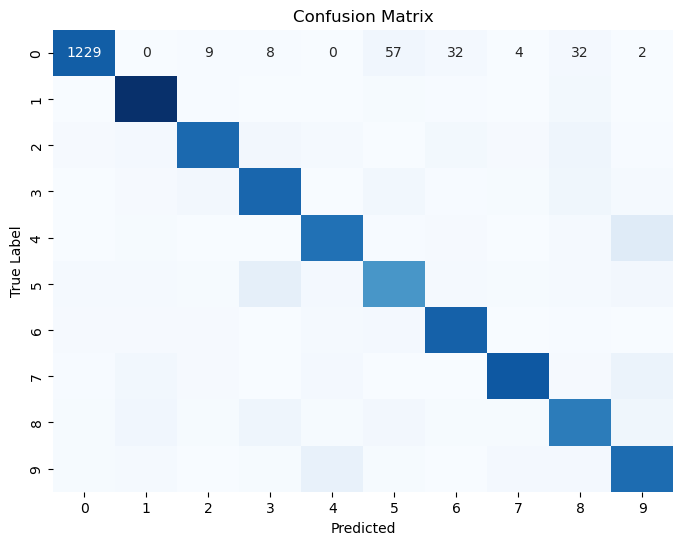

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1373
           1       0.86      0.95      0.90      1569
           2       0.89      0.81      0.85      1430
           3       0.81      0.84      0.82      1413
           4       0.82      0.81      0.82      1376
           5       0.80      0.72      0.76      1253
           6       0.89      0.90      0.90      1339
           7       0.92      0.85      0.89      1483
           8       0.77      0.78      0.77      1365
           9       0.74      0.82      0.78      1399

    accuracy                           0.84     14000
   macro avg       0.84      0.84      0.84     14000
weighted avg       0.84      0.84      0.84     14000

0.8405


In [12]:
nb_predict = naive_gaussian.predict(Xn_test)

cm = confusion_matrix(y_test, nb_predict)

# Plota a matriz de confusão como um mapa de calor (heatmap)
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, nb_predict))
print(accuracy_score(y_test, nb_predict))

## Decision Tree

### Training original dataset

In [12]:
tree_mnist = DecisionTreeClassifier()

param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(estimator=tree_mnist, param_grid=param_grid, cv=5)

grid_search.fit(X_val, y_val)

best_params = grid_search.best_params_

print("Best params:")
print(best_params)

Best params:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [13]:
tree_mnist = DecisionTreeClassifier(criterion='entropy', random_state=0, min_samples_split=5, min_samples_leaf=5, max_depth=10)
tree_mnist.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=5, random_state=0)

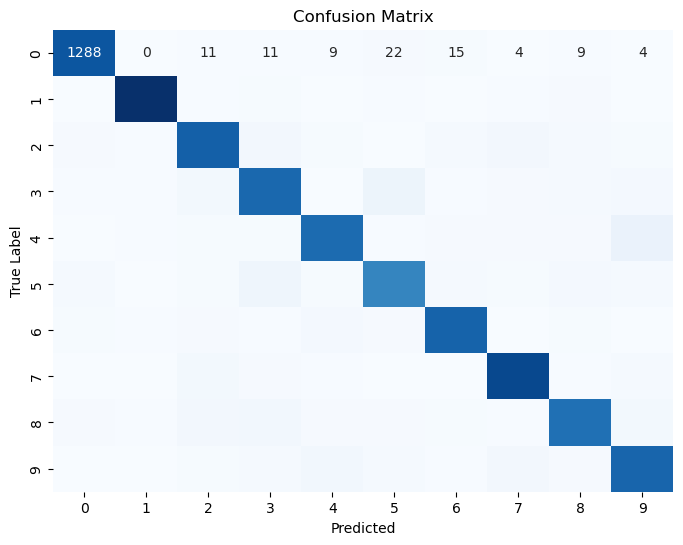

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1373
           1       0.97      0.96      0.97      1569
           2       0.86      0.86      0.86      1430
           3       0.82      0.84      0.83      1413
           4       0.88      0.85      0.86      1376
           5       0.83      0.81      0.82      1253
           6       0.91      0.90      0.91      1339
           7       0.89      0.92      0.91      1483
           8       0.86      0.83      0.85      1365
           9       0.82      0.86      0.84      1399

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000

0.879


In [14]:
tree_predict = tree_mnist.predict(X_test)

cm = confusion_matrix(y_test, tree_predict)

plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, tree_predict))
print(accuracy_score(y_test, tree_predict))

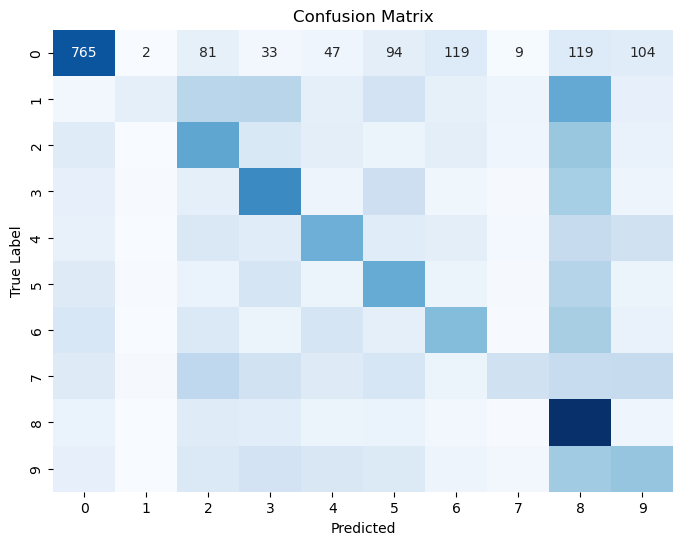

              precision    recall  f1-score   support

           0       0.49      0.56      0.52      1373
           1       0.64      0.05      0.10      1569
           2       0.28      0.34      0.31      1430
           3       0.33      0.41      0.37      1413
           4       0.36      0.32      0.34      1376
           5       0.31      0.37      0.33      1253
           6       0.39      0.29      0.33      1339
           7       0.48      0.12      0.19      1483
           8       0.26      0.65      0.37      1365
           9       0.29      0.25      0.27      1399

    accuracy                           0.33     14000
   macro avg       0.38      0.34      0.31     14000
weighted avg       0.39      0.33      0.31     14000

0.33071428571428574


In [18]:
tree_predict = tree_mnist.predict(Xn_test)

cm = confusion_matrix(y_test, tree_predict)

plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, tree_predict))
print(accuracy_score(y_test, tree_predict))

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10))
plot_tree(tree_mnist, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8',' 9'], filled=True)
fig.savefig('tree_mnist.png')

### Training with noise

In [6]:
tree_mnist = DecisionTreeClassifier(criterion='entropy', random_state=0, min_samples_split=5, min_samples_leaf=5, max_depth=10)
tree_mnist.fit(Xn_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=5, random_state=0)

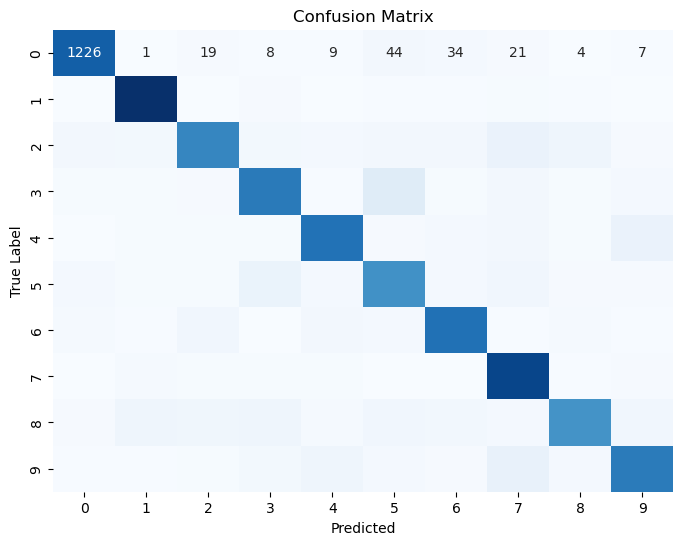

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1373
           1       0.89      0.95      0.92      1569
           2       0.82      0.70      0.76      1430
           3       0.78      0.76      0.77      1413
           4       0.82      0.81      0.82      1376
           5       0.69      0.75      0.72      1253
           6       0.82      0.84      0.83      1339
           7       0.76      0.93      0.84      1483
           8       0.82      0.68      0.74      1365
           9       0.80      0.76      0.78      1399

    accuracy                           0.81     14000
   macro avg       0.81      0.81      0.81     14000
weighted avg       0.81      0.81      0.81     14000

0.8092857142857143


In [7]:
tree_predict = tree_mnist.predict(X_test)

cm = confusion_matrix(y_test, tree_predict)

plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, tree_predict))
print(accuracy_score(y_test, tree_predict))

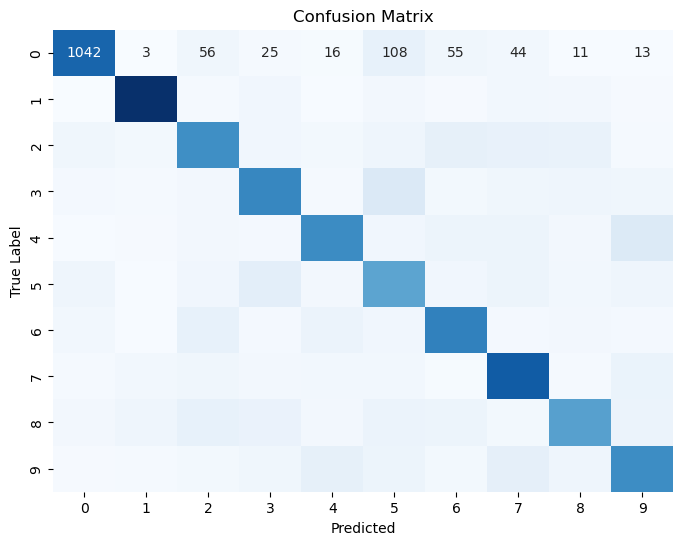

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1373
           1       0.84      0.84      0.84      1569
           2       0.61      0.59      0.60      1430
           3       0.63      0.62      0.62      1413
           4       0.67      0.62      0.64      1376
           5       0.50      0.57      0.53      1253
           6       0.65      0.68      0.66      1339
           7       0.65      0.73      0.69      1483
           8       0.63      0.54      0.58      1365
           9       0.60      0.60      0.60      1399

    accuracy                           0.66     14000
   macro avg       0.66      0.65      0.65     14000
weighted avg       0.66      0.66      0.66     14000

0.6574285714285715


In [8]:
tree_predict = tree_mnist.predict(Xn_test)

cm = confusion_matrix(y_test, tree_predict)

plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, tree_predict))
print(accuracy_score(y_test, tree_predict))

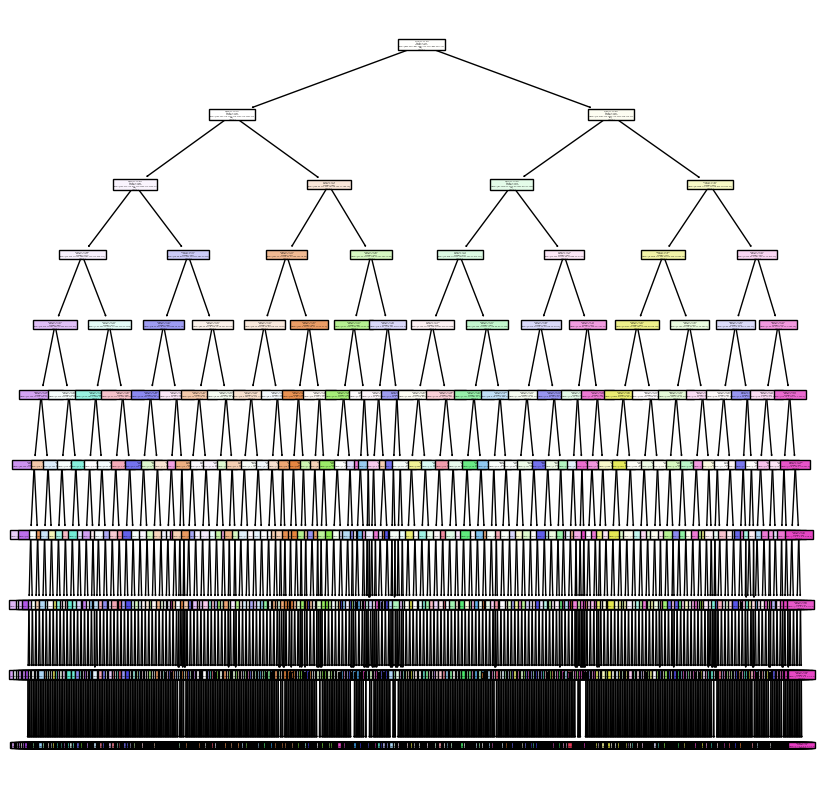

In [11]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10))
plot_tree(tree_mnist, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8',' 9'], filled=True)
fig.savefig('tree_mnist_noisy.png')

## Support Vector Machine

### Training original dataset

In [12]:
svm_mnist = svm.SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=svm_mnist, param_grid=param_grid, cv=5)

grid_search.fit(X_val, y_val)

best_params = grid_search.best_params_

print("Best params: ")
print(best_params)

Best params: 
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [13]:
svm_mnist = svm.SVC(C=10, gamma='scale', kernel='rbf')
svm_mnist.fit(X_train, y_train)

SVC(C=10)

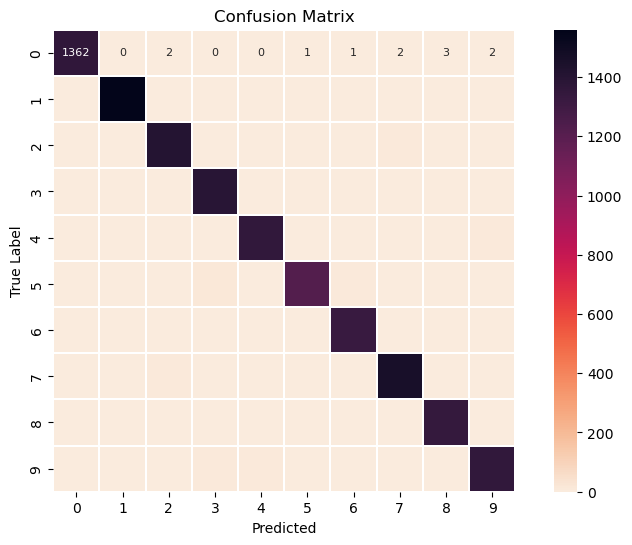

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1373
           1       0.99      0.99      0.99      1569
           2       0.99      0.98      0.98      1430
           3       0.98      0.99      0.98      1413
           4       0.99      0.98      0.98      1376
           5       0.99      0.97      0.98      1253
           6       0.99      0.99      0.99      1339
           7       0.98      0.98      0.98      1483
           8       0.98      0.98      0.98      1365
           9       0.98      0.97      0.97      1399

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000

0.9841428571428571


In [14]:
svm_predict = svm_mnist.predict(X_test)

cm = confusion_matrix(y_test, svm_predict)

plt.figure(figsize=(10, 6))
sn.heatmap(cm, cmap=sn.cm.rocket_r, square=True, linewidths=0.1,
                annot=True, fmt='d', annot_kws={"fontsize": 8})
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, svm_predict))
print(accuracy_score(y_test, svm_predict))

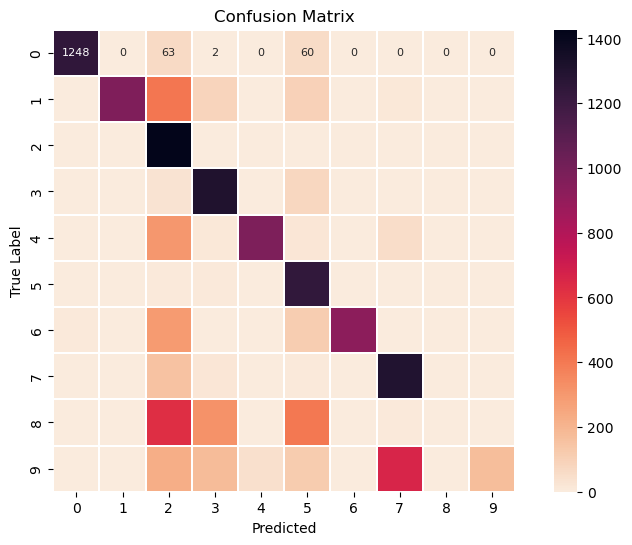

c:\Users\valvs\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1373
           1       0.99      0.62      0.76      1569
           2       0.40      1.00      0.58      1430
           3       0.68      0.93      0.78      1413
           4       0.95      0.71      0.81      1376
           5       0.58      0.99      0.73      1253
           6       1.00      0.69      0.81      1339
           7       0.64      0.88      0.74      1483
           8       0.00      0.00      0.00      1365
           9       0.95      0.12      0.22      1399

    accuracy                           0.68     14000
   macro avg       0.72      0.68      0.64     14000
weighted avg       0.72      0.68      0.64     14000

0.6824285714285714


c:\Users\valvs\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\valvs\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
svm_predict = svm_mnist.predict(Xn_test)

cm = confusion_matrix(y_test, svm_predict)

plt.figure(figsize=(10, 6))
sn.heatmap(cm, cmap=sn.cm.rocket_r, square=True, linewidths=0.1,
                annot=True, fmt='d', annot_kws={"fontsize": 8})
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, svm_predict))
print(accuracy_score(y_test, svm_predict))

### Training with noise

In [16]:
svm_mnist = svm.SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=svm_mnist, param_grid=param_grid, cv=5)

grid_search.fit(Xn_val, y_val)

best_params = grid_search.best_params_

print("Best params: ")
print(best_params)

Best params: 
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [7]:
svm_mnist = svm.SVC(C=10, gamma='scale', kernel='rbf')
svm_mnist.fit(Xn_train, y_train)

SVC(C=10)

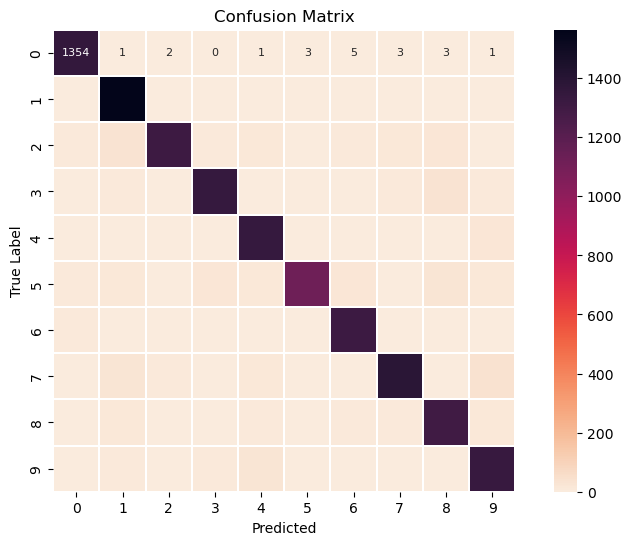

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1373
           1       0.93      1.00      0.96      1569
           2       0.98      0.91      0.95      1430
           3       0.97      0.95      0.96      1413
           4       0.94      0.97      0.96      1376
           5       0.99      0.90      0.94      1253
           6       0.96      0.98      0.97      1339
           7       0.97      0.94      0.95      1483
           8       0.93      0.95      0.94      1365
           9       0.93      0.95      0.94      1399

    accuracy                           0.96     14000
   macro avg       0.96      0.95      0.96     14000
weighted avg       0.96      0.96      0.96     14000

0.9552857142857143


In [8]:
svm_predict = svm_mnist.predict(X_test)

cm = confusion_matrix(y_test, svm_predict)

plt.figure(figsize=(10, 6))
sn.heatmap(cm, cmap=sn.cm.rocket_r, square=True, linewidths=0.1,
                annot=True, fmt='d', annot_kws={"fontsize": 8})
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, svm_predict))
print(accuracy_score(y_test, svm_predict))

In [9]:
svm_predict = svm_mnist.predict(Xn_test)

cm = confusion_matrix(y_test, svm_predict)

plt.figure(figsize=(10, 6))
sn.heatmap(cm, cmap=sn.cm.rocket_r, square=True, linewidths=0.1,
                annot=True, fmt='d', annot_kws={"fontsize": 8})
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, svm_predict))
print(accuracy_score(y_test, svm_predict))